### Установка и импорт всех необходимых зависимостей

In [1]:
!pip install -q razdel
!pip install -q pymorphy2
!pip install -q git+https://github.com/ahmados/rusynonyms.git
!pip install -q natasha
!pip install -q pyaml-env
!pip install -q captum

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mapclassify 2.6.1 requires networkx>=2.7, but you have networkx 2.6.3 which is incompatible.
momepy 0.7.0 requires networkx>=2.7, but you have networkx 2.6.3 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.8.1 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
scikit-image 0.22.0 requires networkx>=2.8, but you have networkx 2.6.3 which is incompatible.
spopt 0.6.0 requires networkx>=2.7, but you have networkx 2.6.3 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
import os
import sys

path_to_alti = '/kaggle/input/transformer-contributions1/transformer-contributions'
if not path_to_alti in sys.path:
    sys.path.append(path_to_alti)

from src.utils_contributions import *
from src.contributions import (
    ModelWrapper, ClassificationModelWrapperCaptum,
    interpret_sentence, occlusion
)

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd

import nltk
from nltk.corpus import stopwords
import re
import pymorphy2
import razdel
import string
from natasha import (
    MorphVocab,
    NewsMorphTagger,
    NewsEmbedding,
    Segmenter,
    NewsSyntaxParser,
    Doc
)

import torch
import tensorflow_hub as hub
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import (
    AutoTokenizer, AutoConfig,
    AutoModelForSequenceClassification, 
    AutoModel,
)
import numpy as np
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import *
from functools import partial
from collections import defaultdict
from IPython.display import clear_output
import random

from lime.lime_text import LimeTextExplainer
import shap

nltk.download('stopwords')
nltk.download('punkt')
rus_stopwords = stopwords.words('russian')
punctuation = list(string.punctuation)

2024-03-12 19:17:54.363773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 19:17:54.363874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 19:17:54.481693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Работа с данными (kaggle)

In [4]:
datasets_folder = '/kaggle/input/sw-datasets/Russian-Sentiment-Analysis-Evaluation-Datasets'
datasets = ['SentiRuEval-2015-telecoms', 'SentiRuEval-2015-banks', 'SentiRuEval-2016-banks', 'SentiRuEval-2016-telecoms']
samples = ['test.xml', 'train.xml', 'test_etalon.xml']

In [5]:
def extract_data(path: str) -> pd.DataFrame:
    """
    функция для извлечения данных из xml
    """
    tree = ET.parse(path)
    root = tree.getroot()
    DataFrame = dict()
    database = root.findall('database')[0]
    DataFrame_columns = list()

    for idx, table in enumerate(database.findall('table')):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']] = list()
            DataFrame_columns.append(column.attrib['name'])
        if idx == 0:
            break

    for table in database.findall('table'):
        for column in table.findall('column'):
            DataFrame[column.attrib['name']].append(column.text)

    data = pd.DataFrame(DataFrame, columns=DataFrame_columns)
    return data

# инициализация всех путей (kaggle)
banks_dataset = datasets[3]
path2samples = os.path.join(datasets_folder, banks_dataset)

dataset_type = 'telecom'
if dataset_type == 'banks':
    banks = ['sberbank', 'vtb', 'gazprom', 'alfabank', 'bankmoskvy', 'raiffeisen', 'uralsib', 'rshb']
    cols_with_reviews = banks
if dataset_type == 'telecom':
    mobile_companies = ['beeline', 'mts', 'megafon', 'tele2', 'rostelecom', 'komstar', 'skylink']
    cols_with_reviews = mobile_companies

path2test = os.path.join(path2samples, samples[2])
data_test = extract_data(path2test)

path2train = os.path.join(path2samples, samples[1])
data_train = extract_data(path2train)

In [6]:
def extract_text_features(data: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """
    функция для первичной обработки текста от лишних символов
    """
    extracted_data = dict()
    extracted_data['text'] = list()
    extracted_data['0class'] = list()
    extracted_data['1class'] = list()

    for idx in range(len(data)):
        row = data.iloc[idx, :]
        reviews = row[cols]
        unique_labels = set(reviews)
        unique_labels.remove('NULL')

        # убираем все ненужные знаки
        filtered_text = re.sub('http[A-z|:|.|/|0-9]*', '', row['text'])
        filtered_text = re.sub('@\S*', '', filtered_text)
        filtered_text = re.sub('#|:|»|«|-|xD|;D|\"|_|/|%', '', filtered_text)
        # filtered_text = re.sub(r'\.(?=\s)|,|(?<!\s)\.(?!\s)|\?', ' ', filtered_text)
        # filtered_text = re.sub(r'[A-Z]|[a-z]', '', filtered_text)
        # filtered_text = re.sub(r'\d+', 'число', filtered_text)
        filtered_text = re.sub(r'\s+', ' ', filtered_text).strip()
        new_text = filtered_text

        # сохраняем только уникальные токены (без придатка xml NULL)
        unique_labels = list(unique_labels)
        while len(unique_labels) < 2:
            unique_labels.append(unique_labels[-1])
        extracted_data['text'].append(new_text)
        for idx, label in enumerate(unique_labels):
            text_label = int(label) + 1
            extracted_data[f'{idx}' + 'class'].append(text_label)

    extracted_data = pd.DataFrame(extracted_data)
    
    # возвращаем dataframe
    return extracted_data

extracted_val = extract_text_features(data_test, cols_with_reviews)
extracted_train = extract_text_features(data_train, cols_with_reviews)

In [7]:
# пример твита из датасета
extracted_val.iloc[1000].text

'нас просто не захотели обслуживать,тк сотрудники болтали между собой. На просьбу обратить на нас внимание они ответили игнором'

### Инициализируем модель (fine-tune) для решения нашей задачи классификации

In [8]:
def load_model_hf_cls(
    model_load: str, model_type: str, 
    load_model_weights: bool=False
) -> torch.nn.Module:

    assert model_type in ['distilbert', 'bert']

    tokenizer = AutoTokenizer.from_pretrained(
        model_load, do_lower_case=True,
        add_additional_tokens=True
    )

    if load_model_weights:
        model = AutoModel.from_pretrained(model_load)
        model_config = model.config
    else:
        model_config = AutoConfig.from_pretrained(model_load)

    model_cls = AutoModelForSequenceClassification.from_config(model_config)
    
    if load_model_weights:
        if model_type == 'distilbert':
            model_cls.distilbert = model
        elif model_type == 'bert':
            model_cls.bert = model
        del model

    return model_cls, tokenizer

In [9]:
distilbert_name = "DeepPavlov/distilrubert-base-cased-conversational"
bert_base_name = "DeepPavlov/rubert-base-cased"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_cls = len(pd.unique(extracted_train['0class']))

model_cls, tokenizer = load_model_hf_cls(
    distilbert_name, model_type='distilbert', 
    load_model_weights=False
)
seq_max_len = model_cls.config.max_position_embeddings
hid_dim = model_cls.config.dim
model_cls.dropout = torch.nn.Identity()
model_cls.pre_classifier = torch.nn.Sequential(
    torch.nn.Linear(hid_dim, hid_dim, bias=False),
    torch.nn.Dropout(0.15),
    torch.nn.ReLU()
)
model_cls.classifier = torch.nn.Sequential(
    torch.nn.Linear(hid_dim, hid_dim, bias=False),
    torch.nn.Dropout(0.15),
    torch.nn.ReLU(),
    torch.nn.Linear(hid_dim, num_cls, bias=False),
)

clear_output()

In [10]:
train_batch_size = 24
val_batch_size = 24

class SentimentDataTransformer(Dataset):
    # инициализация датасета
    def __init__(
        self, texts: List[str], 
        labels: List[Tuple[int, ...]]=None,
        labels_amount: int=1
    ) -> None:

        self.texts = texts
        self.labels = labels

    # для получения размера датасета
    def __len__(self) -> int:
        return len(self.texts)

    # для получения элемента по индексу
    def __getitem__(
        self, index: int
    ) -> Tuple[Union[str, int]]:

        if self.labels is None:
            return self.texts[index]

        text = self.texts[index]
        labels = self.labels[index]
        
        target1, target2 = labels

        return text, target1, target2

In [11]:
class collate_fn_transformers():
    
    def __init__(
        self, tokenizer: AutoTokenizer, 
        use_labels:bool, use_tok_type_ids: bool
    ) -> None:
        
        self.tokenizer = tokenizer
        self.use_tok_type_ids = use_tok_type_ids
        self.use_labels = use_labels
        
    def __call__(self, batch):
        
        if not self.use_labels:

            texts = batch

            return self.tokenizer(
                texts, #truncation=True,
                padding=True, add_special_tokens=True,
                return_token_type_ids=self.use_tok_type_ids,
                return_tensors='pt'
            )
        
        texts, target1, target2 = zip(*batch)
        
        input_ids = self.tokenizer(
            texts, #truncation=True,
            padding=True, add_special_tokens=True,
            return_token_type_ids=self.use_tok_type_ids,
            return_tensors='pt'
        )
        target1 = torch.tensor(target1)
        target2 = torch.tensor(target2)
        
        return input_ids, target1, target2

### Инициализируем наши DataLoaders

In [12]:
train = SentimentDataTransformer(
    texts=extracted_train['text'].tolist(),
    labels=list(zip(extracted_train['0class'], extracted_train['1class']))
)

val = SentimentDataTransformer(
    texts=extracted_val['text'].tolist(),
    labels=list(zip(extracted_val['0class'], extracted_val['1class']))
)

collate_fn_bert = collate_fn_transformers(
    tokenizer=tokenizer, use_tok_type_ids=False, 
    use_labels=True
)

train_loader = DataLoader(
    train, batch_size=train_batch_size,
    shuffle=True, collate_fn=collate_fn_bert
)
val_loader = DataLoader(
    val, batch_size=val_batch_size,
    shuffle=False, collate_fn=collate_fn_bert
)
loaders = {
    'train': train_loader,
    'val': val_loader
}

### Дообучение модели

In [13]:
def train_model(
    epochs: int, model: torch.nn.Module, loaders: Dict[str, DataLoader], 
    optimizer: torch.optim, scheduler: torch.optim.lr_scheduler, 
    weights_vector: torch.tensor=None, device: str='cpu'
) -> None:
    # cross entropy loss
    model = model.to(device)
    if weights_vector is None:
        weights_vector = torch.ones(size=(num_cls,), device=device)
    loss_function1 = torch.nn.CrossEntropyLoss(reduction='mean', weight=weights_vector)
    loss_function2 = torch.nn.CrossEntropyLoss(reduction='mean', weight=weights_vector)
    
    # извлечение DataLoaders
    if len(loaders) > 1:
        train_loader = loaders['train']
        val_loader = loaders['val']
        steps_per_epoch = [('train', train_loader), ('val', val_loader)]
    else:
        train_loader = loaders['train']
        steps_per_epoch = [('train', train_loader)]

    # обучение по эпохам
    for epoch in range(epochs):
        for mode, loader in steps_per_epoch:
            # сохранение статистик
            train_loss = 0
            n_correct = 0
            processed_data = 0
            
            # train/val 
            if mode == 'train':
                model.train()
                requires_grad_mode = True
            else:
                model.eval()
                requires_grad_mode = False
            
            # проход по батчам
            for inputs, trg1, trg2 in tqdm(loader):
                # обнуляем градиенты
                optimizer.zero_grad()

                # извлечение входных данных для модели
                for key, value in inputs.items():
                    inputs[key] = value.to(device)
                trg1, trg2 = trg1.to(device), trg2.to(device)
                inputs['return_dict'] = True
                
                # устанавливаем необходимость вычислять/не_вычислять градиенты
                with torch.set_grad_enabled(requires_grad_mode):
                    outputs = model(**inputs)
                    preds = torch.argmax(outputs['logits'], dim=1)

                    # настраиваем модели на конкретный target
                    if all(trg1 == trg2):
                        loss1 = loss_function1(outputs['logits'], trg1)
                        train_loss += loss1.item()
                        n_correct += torch.sum(preds == trg1).cpu().detach().numpy()
                        if mode == 'train':
                            # вычисляем градиенты и обновляем веса
                            loss1.backward()
                            optimizer.step()
                    # если у твита более чем 1 метка, то настраиваем на обе
                    else:
                        loss1 = loss_function1(outputs['logits'], trg1) * 0.5
                        loss2 = loss_function2(outputs['logits'], trg2) * 0.5
                        loss_all = loss1 + loss2
                        train_loss += loss_all.item()

                        mask_singular = trg1 == trg2
                        mask_multiple = trg1 != trg2
                        singular = preds[mask_singular]
                        n_correct += torch.sum(
                            singular == trg1[mask_singular]
                        ).cpu().detach().numpy()
                        multiple = preds[mask_multiple]
                        n_correct += torch.sum(
                            (multiple == trg1[mask_multiple]) | (multiple == trg2[mask_multiple])
                        ).cpu().detach().numpy()
                        if mode == 'train':
                            # вычисляем градиенты и обновляем веса
                            loss_all.backward()
                            optimizer.step()

                    processed_data += len(preds)

            # вычисляем ошибку и точность прогноза на эпохе
            loader_loss = train_loss / processed_data
            loader_acc = n_correct / processed_data
            print(f'{epoch + 1} epoch with {mode} mode has: {loader_loss} loss, {loader_acc} acc')
        
        # делаем шаг для sheduler оптимайзера
        scheduler.step()

In [14]:
model_name = 'distilbert_cls.pth'

mode_process = input('Load weights? (y/n)')
if mode_process == 'n':
    torch.save(model_cls.state_dict(), model_name)
elif mode_process == 'y':
    model_cls.load_state_dict(
        torch.load('/kaggle/input/distilbert-teltecoms/distilbert_cls_telecom_2016.pth')\
    )
    print('all is matched!')
else:
    assert mode_process in ['n', 'y']
model_cls.eval()
None

Load weights? (y/n) y


all is matched!


### Вычисление итоговых показателей

In [15]:
def pass_data_transformers(
    model: torch.nn.Module, loader: DataLoader,
    loader_labels: bool=False, return_embs: bool=False,
    device: str='cpu', verbose: bool=False
) -> Tuple[np.array, Optional[np.array], Optional[np.array]]:
    """
    pass data from loader through bert model
    """
    model.eval()
    model = model.to(device)

    if verbose:
        pbar = tqdm(len(loader), leave=True, position=0)
    
    with torch.no_grad():

        all_probs = list()
        if loader_labels:
            all_labels1 = list()
            all_labels2 = list()
        if return_embs:
            all_embs = list()
        for idx, inputs in enumerate(loader):

            if loader_labels:
                ids, trg1, trg2 = inputs
            else:
                ids = inputs
            ids = ids.to(device)
            ids['return_dict'] = True
            outputs = model(**ids)
            logits = outputs['logits']
            if return_embs:
                embs = outputs['hidden_states'][-1][:, 0, :]
                all_embs.append(embs.cpu().detach().numpy())

            probs = torch.nn.functional.softmax(
                logits, dim=1
            ).cpu().detach().numpy()
            all_probs.append(probs)
            if loader_labels:
                all_labels1.append(trg1.cpu().detach().numpy())
                all_labels2.append(trg2.cpu().detach().numpy())

            if verbose:
                pbar.update(1)
                pbar.set_description(f'processed: {idx + 1}')

        all_probs = np.vstack(all_probs)
        if loader_labels:
            all_labels1 = np.hstack(all_labels1)
            all_labels2 = np.hstack(all_labels2)
        if return_embs:
            all_embs = np.vstack(all_embs)

    return_data = [all_probs]
    if loader_labels:
        return_data.append(all_labels1)
        return_data.append(all_labels2)
    if return_embs:
        return_data.append(all_embs)

    if len(return_data) > 1:
        return tuple(return_data)
    else:
        return return_data[0]

In [16]:
def calculate_accuracy(
    model: torch.nn.Module, loader: DataLoader,
    device: str='cpu', verbose: bool=True
) -> float:
    model.eval()
    model = model.to(device)
    
    # проход по батчам
    probs, trg1, trg2 = pass_data_transformers(
        model=model, loader=loader, device=device,
        loader_labels=True, verbose=verbose
    )
    preds = np.argmax(probs, axis=1)
    mask_singular = trg1 == trg2
    mask_multiple = trg1 != trg2
    singular = preds[mask_singular]
    n_correct = np.sum(singular == trg1[mask_singular])
    multiple = preds[mask_multiple]
    if len(multiple) > 0:
        n_correct += np.sum(
            
            (multiple == trg1[mask_multiple]) | (multiple == trg2[mask_multiple])
        )
    loader_acc = n_correct / len(preds)

    return loader_acc

def calculate_f1_class(
    model: torch.nn.Module, loader: DataLoader,
    class_num: int, device: str='cpu', verbose: bool=True
) -> float:
    model.eval()
    model = model.to(device)
    all_preds = list()
    groud_truth = list()

    # проход по батчам
    probs, trg1, trg2 = pass_data_transformers(
        model=model, loader=loader, device=device,
        loader_labels=True, verbose=verbose
    )
    preds = np.argmax(probs, axis=1)

    mask_preds = preds == class_num
    preds[mask_preds] = 1
    preds[~mask_preds] = 0
    trg = np.zeros(len(preds))
    mask_trg = (trg1 == class_num) | (trg2 == class_num)
    trg[mask_trg] = 1
    trg[~mask_trg] = 0

    return f1_score(trg, preds)

In [17]:
test_acc = calculate_accuracy(model_cls, val_loader, device)
class_neg_f1 = calculate_f1_class(model_cls, val_loader, 0, device)
class_neu_f1 = calculate_f1_class(model_cls, val_loader, 1, device)
class_pos_f1 = calculate_f1_class(model_cls, val_loader, 2, device)

processed: 94: : 94it [00:02, 43.15it/s]
processed: 94: : 94it [00:01, 55.62it/s]
processed: 94: : 94it [00:01, 55.11it/s]
processed: 94: : 94it [00:01, 55.70it/s]


In [18]:
# общая accuracy и f1 по классам
test_acc, class_neg_f1, class_neu_f1, class_pos_f1

(0.7454383622607922,
 0.7858472998137804,
 0.7371134020618556,
 0.5098901098901099)

## Backdoor attacks on neural network(adversial examples)

### USE metric for similarity between original sentence and spoiled sentence

In [20]:
from scipy.spatial.distance import cosine
# Load pre-trained universal sentence encoder model
use_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [21]:
def use_score(
    original: List[str], adversial: List[str],
    use_bert_encoder: bool=False, bert_batch_size: int=24
) -> Tuple[np.array, float]:
    # using DAN from tensorflow
    if not use_bert_encoder:
        global use_encoder
        # get embs of texts
        orig_emb = use_encoder(original)
        adv_emb = use_encoder(adversial)
    # using BERT itself
    else:
        global model_cls
        global tokenizer
        model_cls.eval()
        model_cls = model_cls.to(device)
        # calculate use_score with BERT
        
        orig_data = SentimentDataTransformer(texts=original)
        adv_data = SentimentDataTransformer(texts=adversial)
        collate_fn = collate_fn_transformers(
            tokenizer=tokenizer, use_tok_type_ids=False, 
            use_labels=False
        )
        orig_loader = DataLoader(
            orig_data, batch_size=bert_batch_size,
            shuffle=False, collate_fn=collate_fn
        )
        adv_loader = DataLoader(
            adv_data, batch_size=bert_batch_size,
            shuffle=False, collate_fn=collate_fn
        )

        orig_emb = pass_data_transformers(
            model=model_cls, loader=orig_loader, device=device,
            loader_labels=False, verbose=False, return_embs=True
        )[-1]
        adv_emb = pass_data_transformers(
            model=model_cls, loader=adv_loader, device=device,
            loader_labels=False, verbose=False, return_embs=True
        )[-1]

    # calculate use_score
    orig_lens = np.sqrt(np.sum(orig_emb ** 2, axis=1))
    adv_lens = np.sqrt(np.sum(adv_emb ** 2, axis=1))
    cosine_dist = np.sum(orig_emb * adv_emb, axis=1)
    use_scores = cosine_dist / (orig_lens * adv_lens)

    return use_scores

### Prepare data for interpretation

In [22]:
min_length = 3
print(f'Кол-во текстов, длина которых больше {min_length}:"')
mask = extracted_val['text'].apply(lambda x: len(list(razdel.tokenize(x)))) > min_length
print(np.sum(mask))
print('Баланс классов:')
unique_labels, counts = np.unique(extracted_val.loc[mask, '0class'], return_counts=True)
print(unique_labels, counts / np.sum(mask))
adversial_examples = extracted_val[mask].reset_index(drop=True)

Кол-во текстов, длина которых больше 3:"
2233
Баланс классов:
[0 1 2] [0.45006717 0.45096283 0.09897   ]


In [24]:
def filter_cols(df: pd.DataFrame) -> pd.DataFrame:
    filtered_cols = [col for col in df.columns if 'unnamed' not in col.lower()]
    df = df.filter(filtered_cols, axis=1)
    ### word
    # filtered_cols = [col for col in df.columns if '3' not in col.lower()]
    # df = df.filter(filtered_cols, axis=1)
    ### char
    # filtered_cols = [col for col in df.columns if '2_1' not in col.lower() and '2_2' not in col.lower()]
    # df = df.filter(filtered_cols, axis=1)
    return df


char_path = '/kaggle/input/adversial-data-fin/adv_texts_char_fin.csv'
char_path_alti_shap = '/kaggle/input/adversial-data-fin/adv_texts_char_shap_alti.csv'
char_path_first = '/kaggle/input/adversial-data-fin/adv_texts_char_first_part.csv'
char_path_second = '/kaggle/input/adversial-data-fin/adv_texts_char_second_part.csv'
adv_texts_first = pd.read_csv(char_path_first, index_col=0)
adv_texts_second = pd.read_csv(char_path_second, index_col=0)
adv_texts_parts = pd.concat((adv_texts_first, adv_texts_second), axis=1)

#adv_texts_alti_shap = pd.read_csv(char_path_alti_shap, index_col=0)
#adv_texts_char = pd.read_csv(char_path, index_col=0)
#adv_texts_char = pd.concat((adv_texts_char, adv_texts_alti_shap), axis=1)

In [25]:
collate_fn_spoiled, batch_size = collate_fn_transformers(
    tokenizer=tokenizer, use_tok_type_ids=False, 
    use_labels=False
), 24
orig_texts = adversial_examples['text'].tolist()
orig_targets = adversial_examples['0class'].to_numpy()
orig_targets_h = adversial_examples['1class'].to_numpy()

adv_scores = {
    'method': list(),
    'asr': list(),
    'bert_use': list(),
    'dan_use': list(),
}
adv_texts_df = adv_texts_parts

for col in adv_texts_df.columns:
    adv_texts = adv_texts_df[col].tolist()
    spoiled_data = SentimentDataTransformer(texts=adv_texts)
    spoiled_loader = DataLoader(
        spoiled_data, batch_size=batch_size,
        shuffle=False, collate_fn=collate_fn_spoiled
    )
    probs = pass_data_transformers(
        model=model_cls, loader=spoiled_loader,
        loader_labels=False, return_embs=False,
        device=device, verbose=True
    )
    preds = np.argmax(probs, axis=1)
    change_preds = ~((preds == orig_targets)|(preds == orig_targets_h))
    change_preds_percent = np.round(
        np.sum(change_preds) / len(change_preds),
        decimals=2
    )

    bert_use_scores = use_score(
        original=orig_texts, adversial=adv_texts,
        use_bert_encoder=True
    )
    dan_use_scores = use_score(
        original=orig_texts, adversial=adv_texts,
        use_bert_encoder=False
    )

    adv_scores['method'].append(col)
    adv_scores['asr'].append(change_preds_percent)
    adv_scores['bert_use'].append(
        np.round(np.mean(bert_use_scores), decimals=2)
    )
    adv_scores['dan_use'].append(
        np.round(np.mean(dan_use_scores), decimals=2)
    )
clear_output()

In [30]:
result = pd.DataFrame(adv_scores)

def convert_method_name(name: str) -> str:
    if '_1_2' in name:
        name = name.replace('_1_2', '_1char_2words')
    elif '_1_1' in name:
        name = name.replace('_1_1', '_1char_1words')
    if 'first_part' in name:
        name = name.replace('first_part', 'fst')
    elif 'second_part' in name:
        name = name.replace('second_part', 'snd')
    return name

result['method'] = result['method'].apply(lambda x: convert_method_name(x))

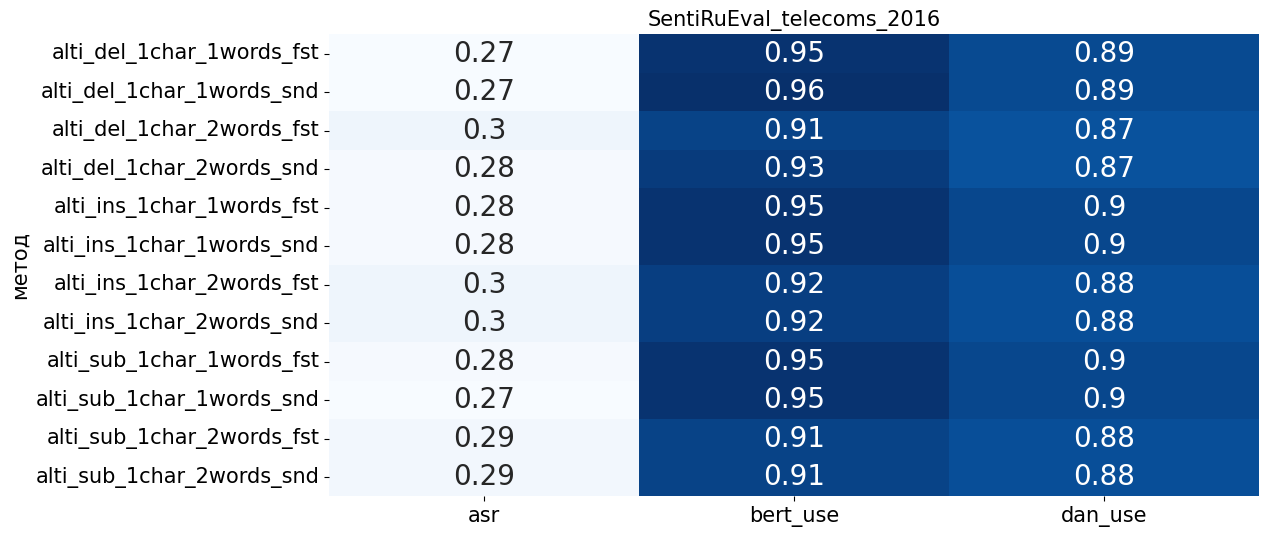

In [37]:
method_names = ['alti']
def check_for_methods(name: str) -> bool:
    for method in method_names:
        if method in name:
            return True
    return False
mask = result['method'].apply(check_for_methods)
result_part = result.loc[mask, :].copy()
result_part.sort_values(by='method', inplace=True, axis=0)

result_part = result_part.set_index('method')

_, axes = plt.subplots(1, 1, figsize=(12, 6))
sns.heatmap(result_part, annot=True, ax=axes, cbar=False, cmap="Blues")
# sns.heatmap(banks_part, annot=True, ax=axes[1], cbar=False, cmap="coolwarm", yticklabels=False)
# axes[1].set_ylabel('')
axes.set_ylabel('метод', fontsize=15)
# axes[1].set_title('SentiRuEval_banks_2016', fontsize=15)
axes.set_title('SentiRuEval_telecoms_2016', fontsize=15)
None

## Interpretation

In [22]:
def gather_back_tokens(tokens: List[str], tokens_type: str) -> str:
    """
    для превращения токенов в предложение
    tokens: список токенов
    tokens_type: natasha или razdel
    """
    assert tokens_type in ['razdel', 'natasha']

    sent = ''
    prev_end = None
    for token in tokens:

        if tokens_type == 'natasha':
            token_text = token['text']
            token_start, token_stop = token['start'], token['stop']
        else:
            token_text = token.text
            token_start, token_stop = token.start, token.stop
        
        if not prev_end is None:
            sent += (token_start - prev_end) * ' '

        sent += token_text
        prev_end = token_stop
 
    return sent

In [23]:
model_cls.eval()
model_cls = model_cls.to(device)

In [24]:
def predict_texts(texts: List[str], func_type: str, batch_size: int=30):
    """
    for Lime: return probability distribution of text
    """
    assert func_type in ['shap', 'lime']
    global tokenizer
    global model_cls
    global device

    if func_type == 'shap':
        texts = list(map(lambda x: re.sub(r'\.{3}', '[MASK]', x), texts))

    # get model outputs
    dataset = SentimentDataTransformer(texts=texts)
    loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        collate_fn=collate_fn_transformers(
            tokenizer=tokenizer, use_labels=False,
            use_tok_type_ids=False
        )
    )
    probs = pass_data_transformers(
        model=model_cls, loader=loader, device=device,
        loader_labels=False, verbose=False, return_embs=False
    )
    
    return probs

### lime

In [25]:
def lime_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str, 
    num_features:int=300, num_samples:int=700
) -> List[str]:
    """
    measure contribution with lime weights
    """
    assert tokens_type in ['razdel', 'natasha']

    def RazdelSplit(text):
        return [raz_tok.text for raz_tok in list(razdel.tokenize(text))]

    def NatashaSplit(text):
        segmenter = Segmenter()
        text_doc = Doc(text.lower())
        text_doc.segment(segmenter)

        return [nat_tok['text'] for nat_tok in text_doc]

    # список для наиболее важных слов
    essential_words = list()
    text_to_explain = gather_back_tokens(tokens, tokens_type)

    if tokens_type == 'razdel':
        Spliter = RazdelSplit
    elif tokens_type == 'natasha':
        Spliter = NatashaSplit
    # создаем Explainer
    explainer = LimeTextExplainer(
        class_names=['Neg', 'Neu', 'Pos'],
        split_expression=Spliter
    )
    # "объясняем" текст
    explanation = explainer.explain_instance(
        text_to_explain, partial(predict_texts, func_type='lime'), 
        num_features=num_features, num_samples=num_samples
    )
    # создаем mapping из токена в его вес LogReg
    explanation_list = explanation.as_list()
    tok2weight = {token:weight for token, weight in explanation_list}
    # создаем список из токенов, их важности и позиции в тексте
    for token in tokens:
        if tokens_type == 'razdel':
            token_text = token.text.lower()
        else:
            token_text = token['text'].lower()

        essential_words.append((
            token, tok2weight[token_text]
        ))
    # создаем функцию сравнения важности
    sort_func = lambda x: np.abs(x[1])
    # сортируем токены по важности
    essential_words = sorted(essential_words, key=sort_func, reverse=True)
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### shap

In [26]:
def shap_importance(
    tokens: List[str], tokens_type: str, target: int
) -> List[str]:
    """
    measure contribution with shap values
    """
    assert tokens_type in ['razdel', 'natasha']

    def custom_tokenizer(
        text: str, return_offsets_mapping=True
    ) -> Dict[str, List[Union[str, Tuple[int, ...]]]]:
        """
        Custom tokenizers conform to a subset 
        of the transformers API
        """
        tokens = list(razdel.tokenize(text))
        
        words = list()
        offsets = list()
        for token in tokens:
            words.append(token.text)
            offsets.append((token.start, token.stop))

        return {
            'input_ids': words,
            'offset_mapping': offsets
        }

    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens,tokens_type)

    masker = shap.maskers.Text(custom_tokenizer)
    explainer = shap.Explainer(
        partial(predict_texts,func_type='shap'), masker, 
        output_names=['Neg', 'Neu', 'Pos']
    )
    # get shap values for the onliest text
    shap_values = explainer([text_to_explain])

    tokens_order = shap_values.data[0]
    base_values = shap_values.base_values
    contributions = shap_values.values[0].sum(axis=1)
    essential_words = list(zip(tokens, contributions))
    # создаем функцию сравнения важности
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(essential_words, key=sort_func, reverse=True)
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### alti

In [27]:
model_cls_wrapper = ModelWrapper(model_cls)

def alti_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str,
    measure_tokens_contributions: str
) -> List[str]:
    """
    measure contribution with alti decomposition
    """
    assert measure_tokens_contributions in ['cls', 'all_tokens']
    assert tokens_type in ['razdel', 'natasha']
    global model_cls_wrapper
    global tokenier
    global model_cls
    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens, tokens_type)

    text_tokens = tokenizer.tokenize(text_to_explain)
    text_input = tokenizer(
        text_to_explain, return_tensors="pt", 
        return_token_type_ids=False,
        return_offsets_mapping=True
    ).to(device)
    offset_mapping = text_input['offset_mapping'][0,1:-1,:].cpu().detach()
    text_input['return_dict'] = True
    del text_input['offset_mapping']

    # get words of text
    pos_words = [(word.start, word.stop) for word in tokens]

    # create mapping from token to word
    cur_index = 0
    token_pos_to_word = dict()
    for idx, (offset, token) in enumerate(zip(offset_mapping, text_tokens)):
        start, _ = offset
        while start >= pos_words[cur_index][1]:
            cur_index += 1
        token_pos_to_word[idx] = tokens[cur_index]

    # get contributions
    _, _, _, contributions_data = model_cls_wrapper(text_input)
    # get Yi from alti
    resultant_norm = torch.norm(
        torch.squeeze(contributions_data['resultants']),
        p=1, dim=-1
    )
    # get Cij from alti method
    # 'contributions' means Tij
    # alti requires scaling = min_sum
    normalized_contributions = normalize_contributions(
        contributions_data['contributions'], scaling='min_sum',
        resultant_norm=resultant_norm
    )
    # apply attention rollout and get seq of Ci
    contributions_mix = compute_joint_attention(normalized_contributions)
    # extract Ci after last self-attention layer
    joint_attention_layer = -1
    contributions_mix_last_hid = contributions_mix[joint_attention_layer]
    # define tokens to measure contributions
    if measure_tokens_contributions == 'cls':
        # contribution to token cls
        positions=np.array([0])
    else:
        # contribution to all tokens
        positions=np.arange(1, len(contributions_mix_last_hid) - 1)

    word_to_contribution = defaultdict(lambda: 0.0)
    for pos in positions:
        # get tokens contrubitons
        contributions_mix_cur = contributions_mix_last_hid[pos][1:-1]
        for idx, contribution in enumerate(contributions_mix_cur):
            word_to_contribution[token_pos_to_word[idx]] += contribution

    # функция для сортировки
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(
        [(word, cont) for word, cont in word_to_contribution.items()],
        key=sort_func, reverse=True
    )
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]
    
    return essential_words

### Heuristic loss

In [28]:
def loss_importance(
    tokens: List[Tuple[str, int, int]], 
    target: Union[int, str], tokens_type: str
) -> List[str]:
    """
    measure contribution with loss changes
    """
    assert tokens_type in ['razdel', 'natasha']
    global device
    global tokenizer
    global model_cls
    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens, tokens_type)
    # список для наиболее важных слов
    essential_words = list()

    loss = torch.nn.CrossEntropyLoss()
    get_inputs = lambda x: tokenizer(
        x, padding=True, add_special_tokens=True,
        return_token_type_ids=False, return_tensors='pt'
    ).to(device)

    # get inputs and outputs from model
    inputs = get_inputs(text_to_explain)
    inputs['return_dict'] = True
    outputs = model_cls(**inputs)['logits']
    target_pt = torch.tensor([target], dtype=torch.long)

    # calculate loss for original text
    loss_score_integral = loss(
        outputs.cpu(), target_pt
    )
    # calculate loss for each token removed
    for idx, token in enumerate(tokens):
        # get text without one token
        tokens_copy = tokens.copy()
        tokens_copy.pop(idx)
        text_to_explain = gather_back_tokens(tokens_copy, tokens_type)
        # calculate loss without current word
        inputs = get_inputs(text_to_explain)
        inputs['return_dict'] = True
        with torch.no_grad():
            outputs = model_cls(**inputs)['logits']
        loss_score_part = loss(outputs.cpu(), target_pt)
        # add our score of change
        essential_words.append((
            token, (loss_score_part-loss_score_integral).cpu().detach().numpy()
        ))

    # создаем функцию сравнения важности
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(essential_words, key=sort_func, reverse=True)
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### attention

In [29]:
def attention_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str,
    measure_tokens_contributions: str
) -> List[str]:
    """
    measure contribution with transformers attention
    """
    assert measure_tokens_contributions in ['cls', 'all_tokens']
    assert tokens_type in ['razdel', 'natasha']
    global tokenier
    global model_cls
    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens, tokens_type)
        
    text_tokens = tokenizer.tokenize(text_to_explain)
    text_input = tokenizer(
        text_to_explain, return_tensors="pt", 
        return_token_type_ids=False,
        return_offsets_mapping=True
    ).to(device)
    offset_mapping = text_input['offset_mapping'][0,1:-1,:].cpu().detach()
    text_input['return_dict'] = True
    del text_input['offset_mapping']

    # get words of text
    pos_words = [(word.start, word.stop) for word in tokens]

    # create mapping from token to word
    cur_index = 0
    token_pos_to_word = dict()
    for idx, (offset, token) in enumerate(zip(offset_mapping, text_tokens)):
        start, _ = offset
        while start >= pos_words[cur_index][1]:
            cur_index += 1
        token_pos_to_word[idx] = tokens[cur_index]
    
    with torch.no_grad():
        contributions_mix_last_hid = compute_rollout(
            torch.cat(
                model_cls(**text_input)['attentions']
            ).mean(dim=1).cpu().detach().numpy()
        )[-1]

    if measure_tokens_contributions == 'cls':
        # contribution to token cls
        positions=np.array([0])
    else:
        # contribution to all tokens
        positions=np.arange(1, len(contributions_mix_last_hid) - 1)

    word_to_contribution = defaultdict(lambda: 0.0)
    for pos in positions:
        # get tokens contrubitons
        contributions_mix_cur = contributions_mix_last_hid[pos][1:-1]
        for idx, contribution in enumerate(contributions_mix_cur):
            word_to_contribution[token_pos_to_word[idx]] += contribution

    # функция для сортировки
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(
        [(word, cont) for word, cont in word_to_contribution.items()],
        key=sort_func, reverse=True
    )
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### gradients

In [30]:
from captum.attr import LayerIntegratedGradients

head_mask = [None] * model_cls.config.num_hidden_layers
use_tok_type_ids=False

def gradient_importance(
    tokens: List[Tuple[str, int, int]], tokens_type: str,
    target: int, alpha_steps: int=20
) -> List[str]:
    """
    measure contribution with gradients
    """
    assert tokens_type in ['razdel', 'natasha']
    global device
    global tokenizer
    global model_cls
    model_cls.eval()
    model_cls = model_cls.to(device)

    def predict(
        input_ids: torch.tensor,
        attention_mask: torch.tensor
    ) -> torch.tensor:
        inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
        logits = model_cls(**inputs)['logits']
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs
        

    # восстанавливаем текст из слов
    text_to_explain = gather_back_tokens(tokens, tokens_type)
    # интегрированные градиенты по слоям модели
    lig = LayerIntegratedGradients(predict, model_cls.distilbert.embeddings)
    
    text_tokens = tokenizer.tokenize(text_to_explain)
    text_input = tokenizer(
        text_to_explain, return_tensors="pt",
        padding=True, add_special_tokens=True,
        return_token_type_ids=use_tok_type_ids,
        return_offsets_mapping=True
    ).to(device)
    offset_mapping = text_input['offset_mapping'][0,1:-1,:].cpu().detach()
    text_input['return_dict'] = True
    del text_input['offset_mapping']
    
    # get words of text
    pos_words = [(word.start, word.stop) for word in tokens]

    # create mapping from token to word
    cur_index = 0
    token_pos_to_word = dict()
    for idx, (offset, token) in enumerate(zip(offset_mapping, text_tokens)):
        start, _ = offset
        while start >= pos_words[cur_index][1]:
            cur_index += 1
        token_pos_to_word[idx] = tokens[cur_index]

    # baseline от которого происходит расчет градиентов
    input_size = text_input["input_ids"].size()
    baseline = torch.zeros(input_size).type(torch.LongTensor).to(device)
    # расчет интегрированных (вдоль пути) градиентов
    attributes, deltas = lig.attribute(
        inputs=text_input["input_ids"], baselines=baseline,
        additional_forward_args=(text_input["attention_mask"]),
        n_steps=alpha_steps, target=torch.tensor(target).to(device),
        return_convergence_delta=True,
    )
    # получаем вклад каждого отдельного токена
    attributes = attributes.sum(dim=-1).squeeze(0)[1:-1]
    toks_contributions = torch.abs(attributes / torch.norm(attributes))
    
    word_to_contribution = defaultdict(lambda: 0.0)
    for idx, contribution in enumerate(toks_contributions):
        word_to_contribution[token_pos_to_word[idx]] += contribution.item()
    
    # функция для сортировки
    sort_func = lambda x: x[1]
    # сортируем токены по важности
    essential_words = sorted(
        [(word, cont) for word, cont in word_to_contribution.items()],
        key=sort_func, reverse=True
    )
    # возвращаем только слова и их позиции в тексте
    essential_words = [word for word, _ in essential_words]

    return essential_words

### random important words

In [31]:
def extract_random_words(
    tokens: List[str]
) -> List[Tuple[str, int]]:
    """
    возвращает список слов в случайном порядке
    """
    permutation = np.random.permutation(len(tokens))

    return [tokens[idx] for idx in permutation]

In [32]:
key_errors = {
    'й': ['ц', 'ы', 'ф'],
    'ц': ['й', 'ы', 'у'],
    'у': ['ц', 'в', 'к'],
    'к': ['у', 'а', 'е'],
    'е': ['к', 'п', 'н'],
    'н': ['е', 'р', 'г'],
    'г': ['н', 'о', 'ш'],
    'ш': ['г', 'л', 'щ'],
    'щ': ['ш', 'д', 'з'],
    'з': ['щ', 'ж'],
    'х': ['ъ', 'э', 'з'],
    'ъ': ['э', 'х'],
    'ф': ['й', 'ы', 'я'],
    'ы': ['ц', 'в', 'ч', 'ф'],
    'в': ['у', 'а', 'с', 'ы'],
    'а': ['к', 'п', 'м', 'в'],
    'п': ['е', 'р', 'и', 'а'],
    'р': ['н', 'о', 'т', 'п'],
    'о': ['г', 'л', 'ь', 'р'],
    'л': ['ш', 'д', 'б', 'о'],
    'д': ['щ', 'ж', 'ю', 'л', 'б'],
    'ж': ['з', 'э', 'ю', 'д'],
    'э': ['х', 'ъ', 'ж'],
    'я': ['ф', 'ы', 'ч'],
    'ч': ['ы', 'в', 'с', 'я'],
    'с': ['в', 'а', 'м', 'ч'],
    'м': ['а', 'п', 'и', 'с'],
    'и': ['п', 'р', 'т', 'м'],
    'т': ['р', 'о', 'ь', 'и'],
    'ь': ['о', 'л', 'б', 'т'],
    'б': ['ь', 'л', 'д', 'ю'],
    'ю': ['д', 'ж', 'б'],
    'r': ['t', 'f', 'e'],
    't': ['y', 'f', 'e'],
    '0': ['9', '-'],
    '1': ['`', '2'],
    '2': ['1', '3'],
    '3': ['2', '4'],
    '4': ['3', '5'],
    '5': ['4', '6'],
    '6': ['5', '7'],
    '7': ['6', '8'],
    '8': ['7', '9'],
    '9': ['8', '0'],
    '-': ['0', '+'],
    'k': ['i', 'j', 'l', 'm'],
    '.': [',', '/', 'l', ';']
}
# получаем словарь формата: буква -> ближайшие буквы на клавиатуре

In [57]:
# здесь может видоизменяться первая буква слова, возможно стоит это исправить
class SpoilTexts:

    def __init__(self) -> None:

        self.texts = None
        self.mv_words_per_text = None
        self.words_to_sub_per_text = None


    @staticmethod
    def post_process_text(text: str) -> str:
        adversial_text = text.strip()
        adversial_text = re.sub(r'\s+', ' ', adversial_text.strip())
        return adversial_text


    @staticmethod
    def get_indexes2change(
        sub_letter: int, token_len: int
    ) -> List[int]:
        """
        функция для получения индексов букв на замену (кроме 0)
        """
        # lst_to_random = list(range(1, token_len))
        lst_to_random = list(range(0, token_len))
        np_ids = np.random.choice(lst_to_random, size=sub_letter, replace=False)

        return np_ids.tolist()


    @staticmethod
    def make_token_change(
        indexes: List[int], token: str, mode='mixed'
    ) -> str:
        """
        фукнция для замены букв по индексам с использованием 4 типов замены:
        del: только удаление
        ins: только вставка
        sub: только замена
        mixed: все вместе сразу
        """
        if mode == 'sub':
            # заменяем букву на позиции
            word = list(token)
            for idx in indexes:
                symbol = word[idx]
                try:
                    word[idx] = random.choice(key_errors[symbol])
                except:
                    pass

        elif mode == 'ins':
            # вставляем букву на позиция и увеличиваем длину токена на 1
            ins_count = 0
            word = list(token)
            indexes = sorted(indexes)
            for idx in indexes:
                symbol = word[idx+ins_count]
                try:
                    word.insert(idx+ins_count, random.choice(key_errors[symbol]))
                    ins_count += 1
                except:
                    pass

        elif mode == 'del':
            # удаляем букву на позиция и уменьшаем длину токена на 1
            del_count = 0
            word = list(token)
            indexes = sorted(indexes)
            for idx in indexes:
                if len(word) == 1:
                    break
                try:
                    word.pop(idx-del_count)
                    del_count += 1
                except:
                    pass

        elif mode == 'mixed':
            ins_count = 0
            del_count = 0
            word = list(token)
            # генерируем самое первое действие в слове
            idx2action = random.randint(0, 2)
            indexes = sorted(indexes)
            for idx in indexes:
                # вставляем букву на позиция и увеличиваем длину токена на 1, если ins
                # удаляем букву на позиция и уменьшаем длину токена на 1, если del
                # заменяем букву на позиции, если sub
                new_idx = idx+ins_count-del_count
                try:
                    if idx2action == 0:
                        symbol = word[new_idx]
                        word[new_idx] = random.choice(key_errors[symbol])
                        idx2action += 1
                    elif idx2action == 1:
                        word.insert(new_idx, random.choice(key_errors[symbol]))
                        ins_count += 1
                        idx2action += 1
                    elif idx2action == 2:
                        word.pop(new_idx)
                        del_count += 1
                        idx2action = 0 
                except:
                    pass

        return ''.join(word)


    def extract_most_valuable_words(
        self, texts: List[str], targets: List[Union[str, int]], 
        method: str, return_words: bool=False, verbose: bool=False
    ) -> None:

        assert method in ['shap', 'lime', 'loss', 'alti', 'random', 'attention', 'gradient']
        self.texts = texts

        if verbose:
            pbar = tqdm(len(self.texts), leave=True, position=0)

        self.mv_words_per_text = list()
        for idx, (text, target) in enumerate(zip(texts, targets)):

            tokens = list(razdel.tokenize(text))
            if len(tokens) == 1:
                self.mv_words_per_text.append(None)
                continue
            tokens_type = 'razdel'

            if method == 'shap':
                words_to_del_order = shap_importance(tokens, tokens_type, target)
            elif method == 'lime':
                words_to_del_order = lime_importance(tokens, tokens_type)
            elif method == 'alti':
                words_to_del_order = alti_importance(tokens, tokens_type, 'cls')
            elif method == 'loss':
                words_to_del_order = loss_importance(tokens, target, tokens_type)
            elif method == 'random':
                words_to_del_order = extract_random_words(tokens)
            elif method == 'attention':
                words_to_del_order = attention_importance(tokens, tokens_type, 'cls')
            elif method == 'gradient':
                words_to_del_order = gradient_importance(tokens, tokens_type, target)

            words_to_del_order = [
                (constr.text, constr.start, constr.stop) 
                for constr in words_to_del_order
            ]
            self.mv_words_per_text.append(words_to_del_order)

            if verbose and (idx % 100 == 0):
                pbar.set_description(f'processed: {idx + 1}')
                pbar.update(1)

        if return_words:
            return self.mv_words_per_text


    def spoil_words(
        self, words_to_sub_count: int, method_to_spoil: str,
        sub: Union[int, float], sub_type: str, verbose: bool=False,
        return_spoiled_words: bool=False
    ) -> None:

        assert method_to_spoil in ['ins', 'del', 'sub', 'mixed']
        assert sub_type in ['percent', 'integer']
        assert sub > 0
        assert words_to_sub_count > 0

        # отслеживание прогресса
        if verbose:
            pbar = tqdm(len(self.mv_words_per_text), leave=False, position=0)
        self.words_to_sub_per_text = list()
        for idx, mv_words in enumerate(self.mv_words_per_text):

            spoiled_tokens, made_subs = list(), 0
            for word, start, stop in mv_words:
                # длина токена
                token_len = stop - start
                # если можно что-то изменить
                if token_len == 1:
                    continue
                # считаем сколько порч символов надо сделать
                if sub_type == 'percent':
                    sub_letter = max(1, int(token_len * sub))
                elif sub_type == 'integer':
                    # контроль, чтобы кол-во замен не превысило длину токена
                    # sub_letter = min(sub, token_len - 1)
                    sub_letter = min(sub, token_len//2)
                # получаем индексы букв на порчу
                indexes = self.get_indexes2change(sub_letter, token_len//2)
                new_indexes = list()
                for idx in indexes:
                    new_indexes.append(idx + token_len//2)
                # портим буквы по полученным индекса
                spoiled_word = self.make_token_change(new_indexes, word, method_to_spoil)
                # повышаем счетчик испорченных слов
                spoiled_tokens.append((spoiled_word, start, stop))
                made_subs += 1
                # если набрали нужное количество испорченных слов
                if made_subs >= words_to_sub_count:
                    break
    
            spoiled_tokens = sorted(spoiled_tokens, key=lambda x: x[1], reverse=False)
            self.words_to_sub_per_text.append(spoiled_tokens)

            if verbose and (idx % 100 == 0):
                pbar.set_description(f'processed: {idx + 1}')
                pbar.update(1)

        if return_spoiled_words:
            return self.words_to_sub_per_text


    def generate_adv_texts(self, verbose: bool=False) -> List[str]:

        assert self.texts is not None
        assert self.mv_words_per_text is not None
        assert self.words_to_sub_per_text is not None
        assert len(self.texts) == len(self.words_to_sub_per_text)

        if verbose:
            pbar = tqdm(len(self.texts), leave=False, position=0)

        adv_texts = list()
        for idx, (text, words_to_sub) in enumerate(
            zip(self.texts, self.words_to_sub_per_text)
        ):
            # заменяем исходные слов в тексте испорченными
            shift = 0
            spoiled_text = list(text.lower())
            for spoiled, start, stop in words_to_sub:
                spoiled_text[start + shift:stop + shift] = spoiled
                shift += len(spoiled) - (stop - start)
            spoiled_text = ''.join(spoiled_text)
            adv_texts.append(spoiled_text)

            if verbose and (idx % 100 == 0):
                pbar.set_description(f'processed: {idx + 1}')
                pbar.update(1)
        
        return adv_texts

In [64]:
texts = adversial_examples['text'].apply(lambda x: x.lower()).tolist()
targets = adversial_examples['0class'].tolist()
spoil_texts_char = SpoilTexts()

model_cls = model_cls.to('cuda:0')
method,  method_to_spoil = 'alti', 'ins'
sub, words_to_sub_count = 1, 1

spoil_texts_char.extract_most_valuable_words(
    texts=texts, targets=targets, method=method, verbose=True
)
spoil_texts_char.spoil_words(
    words_to_sub_count=words_to_sub_count, method_to_spoil=method_to_spoil,
    sub=sub, sub_type='integer', verbose=True
)
adv_texts = spoil_texts_char.generate_adv_texts(verbose=True)
adv_texts_df_h[f'{method}_{method_to_spoil}_{sub}_{words_to_sub_count}'] = adv_texts

processed: 2201: : 23it [04:05, 10.69s/it]
